In [168]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from ipywidgets import interactive
import ipywidgets as widgets

In [169]:
#Import Data
import pandas as pd
#INDEX_COLUMNS = ['Country/Region', 'Province/State']
#arr = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', sep=',',quotechar='"', #quoting=2,na_values = "\\N", er ror_bad_lines=False)

arr_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', sep=',',na_values = "\\N", error_bad_lines=False#, index_col=INDEX_COLUMNS
)
arr_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv', sep=',',na_values = "\\N", error_bad_lines=False#, index_col=INDEX_COLUMNS
)
arr_death = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv', sep=',',na_values = "\\N", error_bad_lines=False#, index_col=INDEX_COLUMNS
)

In [170]:
def melt_csv(df):
    #print(df)

    return df.melt(
        id_vars=df.columns[1], 
        value_vars=df.columns[4:], 
        var_name='date', 
        value_name='value'
    ).dropna()
def proceed_start_paramter_country(country):
    global start_date, last_date, reported_recovered,reported_death, reported_infected, dayQuarantine, reported_critically
    df = melt_csv(arr_confirmed[arr_confirmed["Country/Region"]==country])
    start_date_new = datetime.datetime.strptime(df["date"][0], '%m/%d/%y').date()
    last_date = datetime.datetime.strptime(df["date"][len(df)-1], '%m/%d/%y').date()

    reported_recovered = melt_csv(arr_recovered[arr_recovered["Country/Region"]==country]).value.to_numpy()
    reported_death = melt_csv(arr_death[arr_death["Country/Region"]==country]).value.to_numpy()
    reported_infected = df["value"].to_numpy() - reported_recovered - reported_death
    print("Start date: " + str(start_date))
    print("Start date New: " + str(start_date_new))
    print("Last date: " + str(last_date))
     # If reported start earlier than start parameter, we need to ajust array
    start_diff = abs(start_date - start_date_new).days
    if start_diff>0 :
        reported_recovered = reported_recovered[start_diff:]
        reported_death = reported_death[start_diff:]
        reported_infected = reported_infected[start_diff:]      
    length = abs(last_date - start_date).days
    reported_recovered = fillnull(reported_recovered,length)
    reported_death = fillnull(reported_death,length)
    reported_infected = fillnull(reported_infected,length)
    reported_critically = fillnull(reported_critically,length)

    dayQuarantine = getQuarantine(dayQuarantine)

In [171]:
def sigmoid(t):
    y = 1/ (1+np.exp(-1*t))
    return y

In [172]:
# A grid of time points (in days)
t = np.linspace(0, 700, 701)
def getQuarantine(dayQuarantine):
    day_all=0
    for x in dayQuarantine: 
        day_all = day_all + x
    for x in dateday:
            diff = (x-datetime.timedelta(day_all)-start_date).days
            dayQuarantine = dayQuarantine + (diff,)
            day_all = day_all+diff
    return dayQuarantine

def getSum(tx):
    s=0
    ty=()
    for x in tx:
        s=s+x
        ty = ty + (s,)
    return ty
def getContact(cx,tx,t,dt):
    s=0
    ty=getSum(tx)
    i=0
    y=0
    while i<len(cx)-1:
        y = y+(cx[i]-cx[i+1])*(1-sigmoid((t-ty[i+1])/dt[i+1]))
        i = i+1
    y=y+cx[i]
    return y
def fillnull(A, n):
    m = n-len(A)
    if m>0:
        A = np.concatenate([np.zeros(n-len(A)) , A])
    return A
def proceed_start_paramter():
    global last_date, reported_recovered,reported_death, reported_infected, dayQuarantine, reported_critically
    reported_recovered = getSum(reported_recovered)
    last_date = start_date + datetime.timedelta(days = (len(reported_infected)))
    print("Last date: " + str(last_date))
    length = abs(last_date - start_date)
    reported_recovered = fillnull(reported_recovered,length.days)
    reported_death = fillnull(reported_death,length.days)
    reported_infected = fillnull(reported_infected,length.days)
    reported_critically = fillnull(reported_critically,length.days)
    dayQuarantine = getQuarantine(dayQuarantine)
    print("Quarantine: " + str(dayQuarantine))
    

In [173]:
# The SIR model differential equations
def deriv(y, t, 
       dayQuarantine1,
       contact1,
       dayQuarantine2,
       contact2,
       dayQuarantine3,
       contact3 ,infection_probability,
      #probabilty to get well without strong symtoms. Meens, the person stays inisolated and from Ia changes to R in the time teta_sym. 
      asymtom_probability,
      #time for Incubation and time for symtoms
       teta_inc, teta_sym, 
        recovery_rate, recovery_rate_mild, death_rate,
        #natural_death
        delta,
        #natural_birth
        A,
         quarantine_probability=1):
        
    S, E, Ia, Iu, Is, R, Ra, D = y
    
    #sigmoid
    cx = contact[:(len(contact)-3)] + (contact1,contact2,contact3)
    tx = dayQuarantine[:(len(contact)-3)] + (dayQuarantine1,dayQuarantine2,dayQuarantine3)
    n = getContact(cx,tx,t,deltat + (1,1,1))
    
    #susceptible
    dSdt = -n*infection_probability*(Ia+Iu)/(S+E+Ia+Iu+R+Ra) * S + A - delta*S
    #Exposed
    dEdt = n*infection_probability*(Ia+Iu)/(S+E+Ia+Iu+R+Ra) * S - 1/teta_inc*E- delta*E 
    #Infected asymptomatic
    dIadt = (1/teta_inc * E - 1/(teta_sym - teta_inc)*Ia - delta*Ia 
             - quarantine_probability*1/(teta_sym - teta_inc)*Ia*(1-asymtom_probability)*n*infection_probability*(Ia+Iu)/(S+E+Ia+Iu+R+Ra)) 
    
   
    
    #Infected unregisterted (no quarantine)
    dIudt = 1/(teta_sym - teta_inc)*Ia*(asymtom_probability) - recovery_rate_mild * Iu - delta*Iu
    #Infected symptomatic (quarantine)
    dIsdt = 1/(teta_sym - teta_inc)*Ia*(1-asymtom_probability) - recovery_rate * Is - death_rate*Is
    
    #Recovered
    dRdt = recovery_rate * Is - delta*R 
    #Recovered without symptoms
    dRadt = recovery_rate_mild * Iu - delta*Ra 
    #Dead from Desease
    dDdt = death_rate * Is
    
    
    return dSdt, dEdt, dIadt,dIudt, dIsdt, dRdt, dRadt, dDdt

In [174]:
def solver( 
       dayQuarantine1,
       contact1,
       dayQuarantine2,
       contact2,
       dayQuarantine3,
       contact3):
    # Initial conditions vector
    y0 = S0, E0, Ia0, Iu0, Is0, R0, Ra0, D0
 
    #sigmoid
    #sigmoid
    cx = contact[:(len(contact)-3)] + (contact1,contact2,contact3)
    tx = dayQuarantine[:(len(contact)-3)] + (dayQuarantine1,dayQuarantine2,dayQuarantine3)
    n = getContact(cx,tx,t,deltat + (1,1,1))
    
    # Integrate the SIR equations over the time grid, t.
    args=(
   dayQuarantine1,
   contact1,
   dayQuarantine2,
   contact2,
   dayQuarantine3,
   contact3 ,infection_probability_proz/100, asymptom_probability_proz/100, teta_inc, teta_sym, 
                                 1/recovery_day, 1/recovery_day_mild, death_rate_proz/100,
                                delta, A)
    ret = odeint(deriv, y0, t, args)
    S, E, Ia, Iu, Is, R, Ra, D = ret.T
    dates = [start_date + datetime.timedelta(xval) for xval in t]
    # Plot the data on three separate curves for S(t), E(t(, Ia(t), Is(t) and R(t)
    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

    plt.rcParams.update({'font.size': 12})

    fig = plt.figure(facecolor='w',figsize=[20,50])
    #sigmoid
    ax0 = fig.add_subplot(513, axisbelow=True)    
    ax0.plot(dates, n, color='c', lw=2, label='Contacts Amount')
    ax0.set_xlabel('Time /days')
    ax0.set_ylabel('Contacts')
    ax0.grid(True)
    #Axis
    ax0.yaxis.set_tick_params(length=5)
    ax0.xaxis.set_major_locator(mdates.MonthLocator())
    ax0.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=(1,5,10,15,20,25,30)))
    ax0.xaxis.set_major_formatter(mdates.DateFormatter("%m %d"))
    ax0.xaxis.set_tick_params(length=5)
    
    #big picture
    ax1 = fig.add_subplot(512, axisbelow=True)
    ax1.plot(dates, Iu, color='c', lw=2, label='Infected unregistered')
    ax1.plot(dates, Is, 'red', alpha=0.5, lw=2, label='Infected symtomatic')
    ax1.plot(dates, need_help_proz/100*Is, color='red', alpha=0.5, lw=4, ls="-", label='Need help')
    ax1.plot(dates, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax1.plot(dates, Ra, 'g', alpha=0.5, lw=2, ls = ':', label='Recovered asymtomatic with immunity')
    ax1.plot(dates, D, 'k', alpha=0.5, lw=2, label='Dead')
    ax1.set_xlabel('Time /days')
    ax1.set_ylabel('Population')
    ax1.grid(True)
    ax1.yaxis.set_tick_params(length=5)
    ax1.set_ylim(0, max(Is)*1.5)
    
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=(1,5,10,15,20,25,30)))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    
    #First 250 days
    ax2 = fig.add_subplot(511, axisbelow=True)
    ax2.plot(dates, Iu, color='c', lw=2, label='Infected unregistered')
    ax2.plot(dates, Is, 'red', alpha=0.5, lw=2, label='Infected symtomatic')
    ax2.plot(dates, need_help_proz/100*Is, color='red', alpha=0.5, lw=4, ls="-", label='Need help')
    ax2.plot(dates, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax2.plot(dates, Ra, 'g', alpha=0.5, lw=2, ls = ':', label='Recovered asymtomatic with immunity')
    ax2.plot(dates, D, 'k', alpha=0.5, lw=2, label='Dead')
    ax2.set_xlabel('Time /days')
    ax2.set_ylabel('Population')
    ax2.grid(True)
    ax2.set_ylim(0, max(reported_infected)*2)
    ax2.set_xlim(start_date,start_date +datetime.timedelta(250))
    ax2.yaxis.set_tick_params(length=5)
    
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=(1,5,10,15,20,25,30)))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    
    #First 250 days only infected, dead and needed help
    ax4 = fig.add_subplot(514, axisbelow=True)
    ax4.plot(dates, Is, 'b', alpha=0.5, lw=3, label='Infected symtomatic')
    ax4.plot(dates, need_help_proz/100*Is, color='red', alpha=0.5, lw=4, ls="-", label='Need help')
    ax4.plot(dates, D, 'k', alpha=0.5, lw=2, label='Dead')
    ax4.set_xlabel('Time /days')
    ax4.set_ylabel('Population')
    ax4.grid(True)
    ax4.set_ylim(0, max(reported_infected)*1.3)
    ax4.set_xlim(start_date,start_date +datetime.timedelta(250))
    ax4.yaxis.set_tick_params(length=5)

    ax4.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=(1,5,10,15,20,25,30)))
    
    #big picture only infected, dead and needed help
    ax5 = fig.add_subplot(515, axisbelow=True)
    ax5.plot(dates, Is, 'b', alpha=0.5, lw=3, label='Infected symtomatic')
    ax5.plot(dates, need_help_proz/100*Is, color='red', alpha=0.5, lw=4, ls="-", label='Need help')
    ax5.plot(dates, D, 'k', alpha=0.5, lw=2, label='Dead')
    ax5.set_xlabel('Time /days')
    ax5.set_ylabel('Population')
    ax5.grid(True)
    ax5.yaxis.set_tick_params(length=5)
    ax5.set_ylim(0, max(Is)*1.1)
    ax4.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=(1,5,10,15,20,25,30)))
    
    #Axis
    
    
    day1 = start_date + datetime.timedelta(dayQuarantine1)
    day2 = day1 + datetime.timedelta(dayQuarantine2)
    day3 = day2 + datetime.timedelta(dayQuarantine3)
    i=0
    day = start_date
    preday = start_date
    #colors=plt.rainbow(np.linspace(0,1,len(tx)))
    colors = ("cornsilk","snow","azure")
    for tt in tx:    
        preday = day
       
        day = day +datetime.timedelta(tt)
        ax1.axvline(x=day, color = "k", lw=2, label="Q w. "+str(cx[i]) + "contacts on " + 
                   str(day), ls=":")
        ax2.axvline(x=day, color = "k", lw=2, label="Q w. "+str(cx[i]) + "contacts on " + 
                   str(day), ls=":")
        ax4.axvline(x=day, color = "k", lw=2, label="Q w. "+str(cx[i]) + "contacts on " + 
                   str(day), ls=":")
        ax5.axvline(x=day, color = "k", lw=2, label="Q w. "+str(cx[i]) + "contacts on " + 
                   str(day), ls=":")
        

        if i>0:
            #plt.axvspan(preday, day, facecolor=colors[(i%3)-1], alpha=0.5)
            [this_ax.axvspan(preday, day, facecolor=colors[(i%3)-1], alpha=0.5) for this_ax in [ax1,ax2,ax4,ax5]]
        i=i+1

    
    ax1.axhline(y=bed_capacity, color = "k", lw=3, ls="-", label="Bed capacity vs. " + 
                str(round(max(Is)*need_help_proz/bed_capacity,0))+"%")
    ax2.axhline(y=bed_capacity, color = "k", lw="3", label="Bed capacity vs." + 
                str(round(max(Is)*need_help_proz/bed_capacity,0))+"%")
    ax4.axhline(y=bed_capacity, color = "k", lw="3", label="Bed capacity vs." + 
                str(round(max(Is)*need_help_proz/bed_capacity,0))+"%")
    ax5.axhline(y=bed_capacity, color = "k", lw="3", label="Bed capacity vs." + 
                str(round(max(Is)*need_help_proz/bed_capacity,0))+"%")
    
    #plot reported data
    ax2.plot(dates[:len(reported_death)],reported_death,'kx', label='Reported deaths')
    ax2.plot(dates[:len(reported_critically)],reported_critically,'rx', label='Reported critically')
    ax2.plot(dates[:len(reported_recovered)],reported_recovered,'go', label='Reported recovered')
    ax2.plot(dates[:len(reported_infected)],reported_infected,'ro', label='Reported infected')

    ax4.plot(dates[:len(reported_death)],reported_death,'kx', label='Reported deaths')
    ax4.plot(dates[:len(reported_critically)],reported_critically,'rx', label='Reported critically')
    ax4.plot(dates[:len(reported_infected)],reported_infected,'ro', label='Reported infected')


    ax5.plot(dates[:len(reported_death)],reported_death,'kx', label='Reported deaths')
    ax5.plot(dates[:len(reported_critically)],reported_critically,'rx', label='Reported critically')
    ax5.plot(dates[:len(reported_infected)],reported_infected,'ro', label='Reported infected')


    legend = ax1.legend()
    legend = ax2.legend()
    legend = ax0.legend()
    legend = ax4.legend(loc = 'upper right')
    legend = ax5.legend(loc = 'upper right')
    
    plt.show()
    
    prediction_delta = 7
    x_prediction=(datetime.date.today() - start_date).days+prediction_delta
    dat_prediction = datetime.date.today() + datetime.timedelta(days = prediction_delta)
    dat_end = start_date + datetime.timedelta(days = len(D)-1)
    x_end = len(D)-1
    x_now = len(reported_infected)-1
    
    print(str(last_date) + " Infected: " + str(round(Is[x_now],0)) +
          "Diff: " + str(round(Is[x_now],0) - reported_infected[x_now]))
    print(str(last_date) + " Dead: " + str(round(D[x_now],0)) + 
          "Diff: " + str(round(D[x_now],0) - reported_death[x_now]))
    print(str(dat_prediction) + " Infected: " + str(round(Is[x_prediction],0)) + " Dead: " + str(round(D[x_prediction],0)))
    print(str(dat_end) + " Prediction Dead: " + str(round(D[x_end],0)))
    print(str(Iu[x_now]/(Is[x_now]+Iu[x_now])*100) + " % are Ill and unregistered today")
    print(str(Ra[x_now]/(R[x_now]+Ra[x_now])*100) + " % are Recovered and unregistered today")
    print(str(Ra[x_end]/(R[x_end]+Ra[x_end])*100) + " % are Recovered unregistered total")
    print(str(Ra[x_now]+(R[x_now])) + " are Recovered total")
    
    

In [175]:
def show_plot():
    interactive_plot = interactive(solver, 
                               dayQuarantine1=dayQuarantine[len(dayQuarantine)-3],
                               contact1 =contact[len(dayQuarantine)-3],
                               dayQuarantine2=dayQuarantine[len(dayQuarantine)-2],
                               contact2 =contact[len(dayQuarantine)-2],
                               dayQuarantine3=dayQuarantine[len(dayQuarantine)-1],
                               contact3 =contact[len(dayQuarantine)-1]
                               
                              )
    output = interactive_plot.children[-1]
    output.layout.height = '1000px'
    return interactive_plot

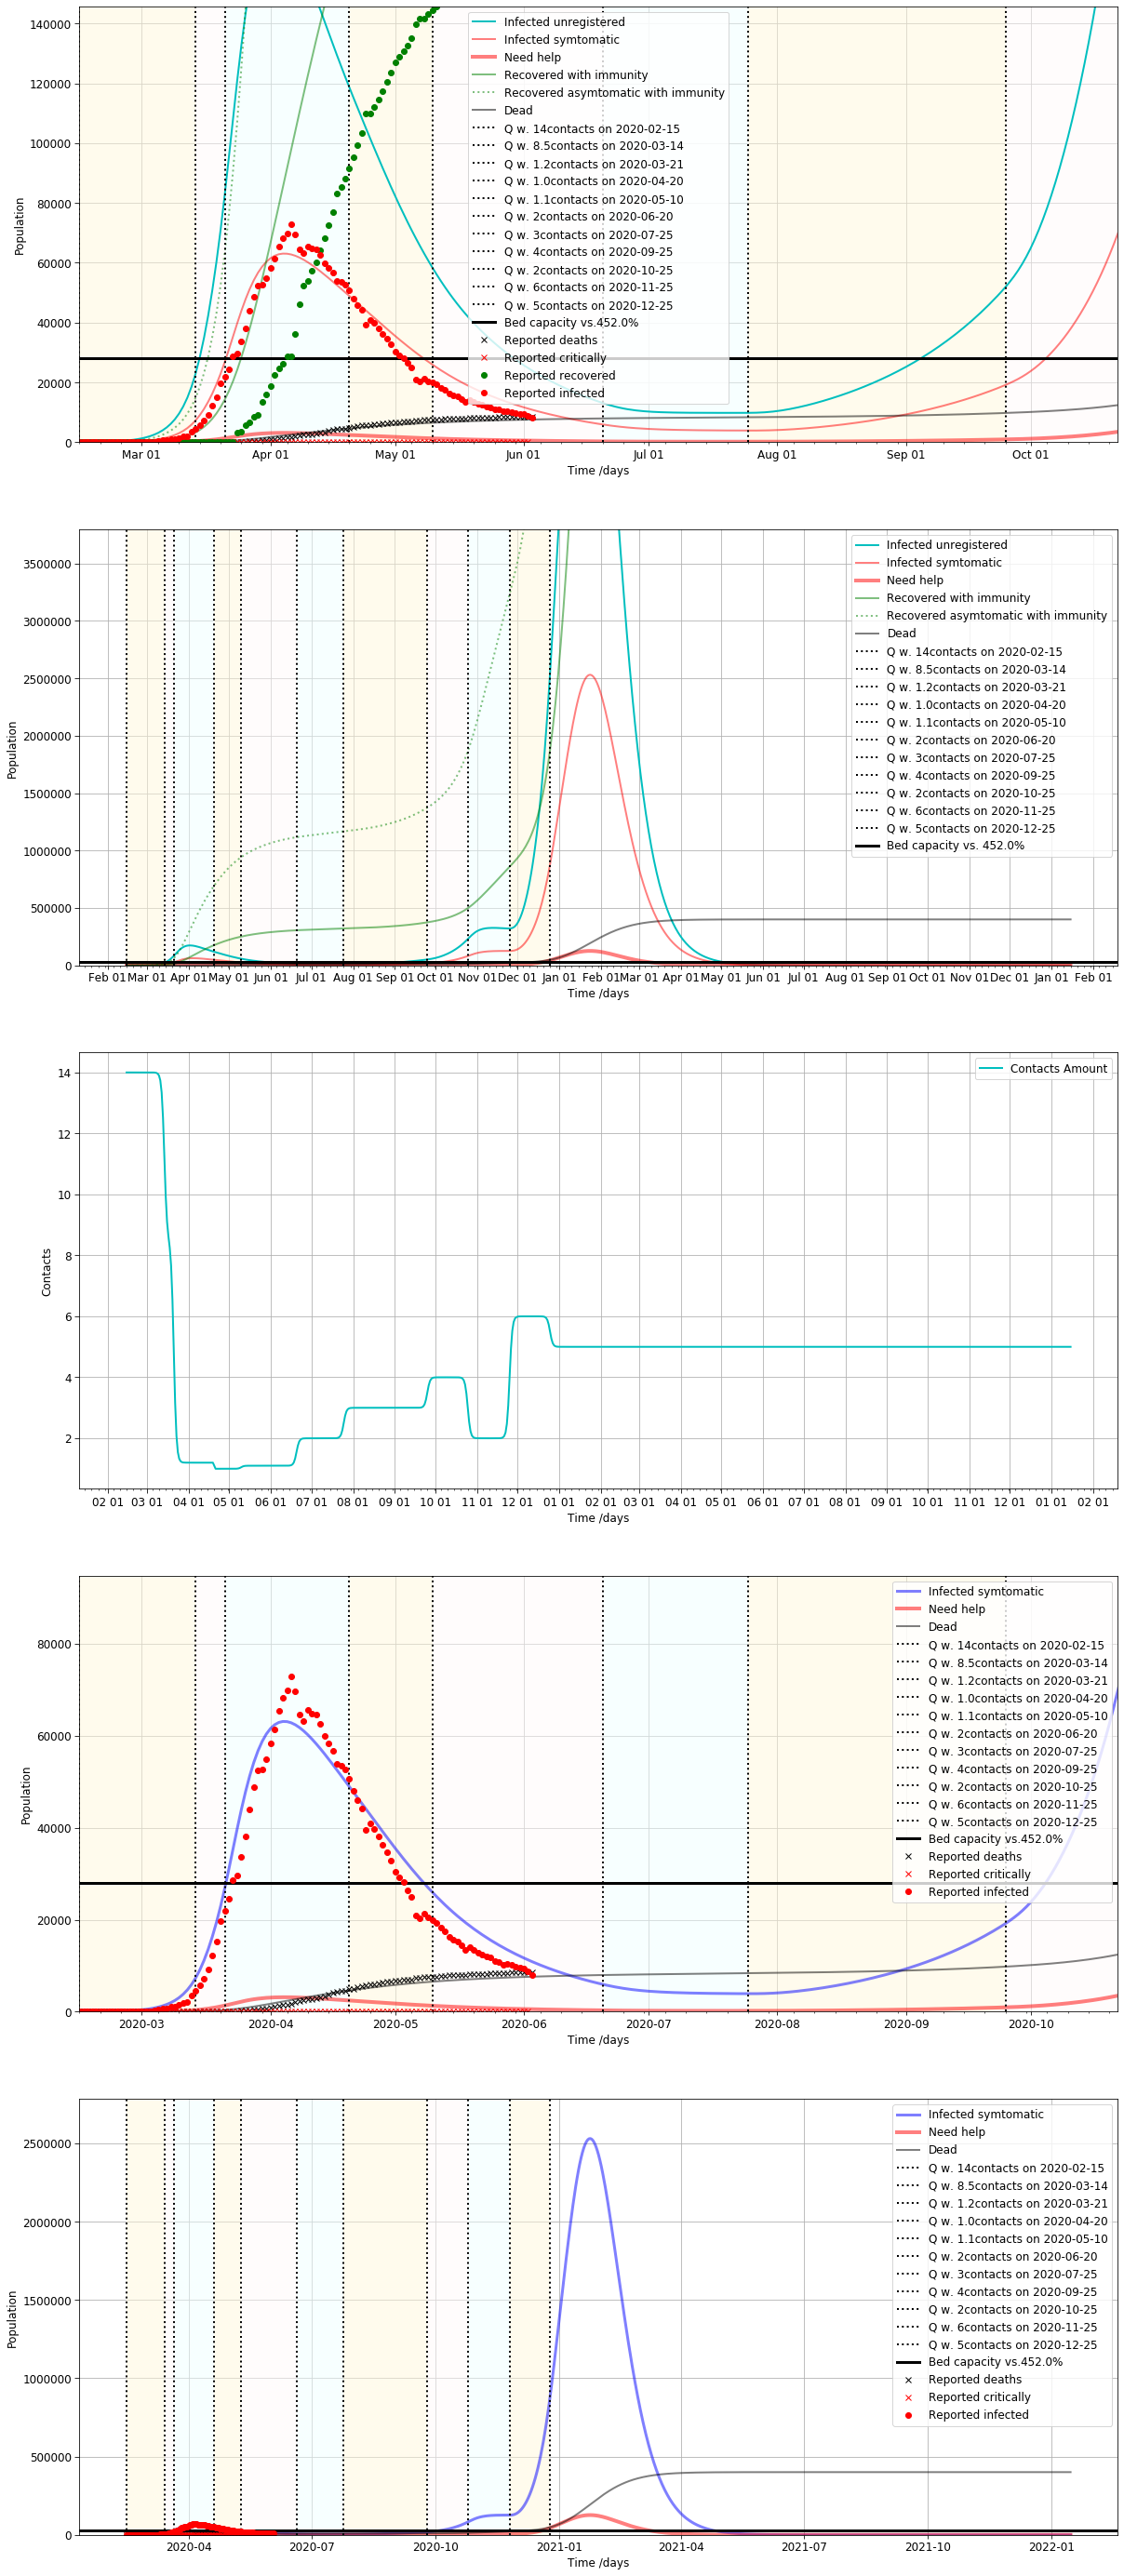

2020-06-03 Infected: 10878.0Diff: 2812.0
2020-06-03 Dead: 7614.0Diff: -988.0
2020-06-11 Infected: 8187.0 Dead: 7811.0
2022-01-15 Prediction Dead: 400738.0
68.7920120155075 % are Ill and unregistered today
78.58890148455376 % are Recovered and unregistered today
78.36035915914107 % are Recovered unregistered total
1365867.746555841 are Recovered total


In [176]:
import datetime
##Germany

# Total population, N.
N = 80*1000000
#natural death rate
delta = 11/1000/365
#natural birth_rate https://www.destatis.de/EN/Themes/Society-Environment/Population/Births/Tables/birth-deaths.html;jsessionid=D12FBB60A572EE37276ED5A4E5B23FE5.internet711
A = 9.5/1000*N/365
# Initial number of exposed, infected and recovered individuals.
E0, Ia0, Is0, R0, Ra0, D0 = 570, 40, 0, 0, 0, 0
Iu0 = 0
start_date = datetime.date(2020,2,15)
reported_critically = (0,)
dayQuarantine=(0,) 
contact=(14,8.5,1.2,1.0,1.1,2,3,4,2,6,5)
deltat = (0.1,1,1,0.1,1,1,1,1,1,1)

dateday=(       
        datetime.date(2020,3,14), # school closed 
        datetime.date(2020,3,21), # partial lock down
         datetime.date(2020,4,20), # partial open
         datetime.date(2020,5,10),
         datetime.date(2020,6,20),
         datetime.date(2020,7,25),
         datetime.date(2020,9,25),
         datetime.date(2020,10,25),
         datetime.date(2020,11,25),
         datetime.date(2020,12,25)

)
#proceed_start_paramter()
proceed_start_paramter_country("Germany")

Gamma=0.043 #0.0433107
CurlyEpsilon= 0.0152658
Phi=  0.22073
Psi= 1.

bed_capacity = 28000
death_rate_proz = 0.26#CurlyEpsilon*100
need_help_proz = 5
 
infection_probability_proz=Gamma*100
asymptom_probability_proz=(1-Phi)*100
teta_inc = 5.1
teta_sym = 11.5
recovery_day= 10#16
recovery_day_mild= 7

# Everyone else, S0, is susceptible to infection initially.
S0 = N - (E0 + Ia0 + Is0 + R0 + D0 + Ra0)

show_plot()


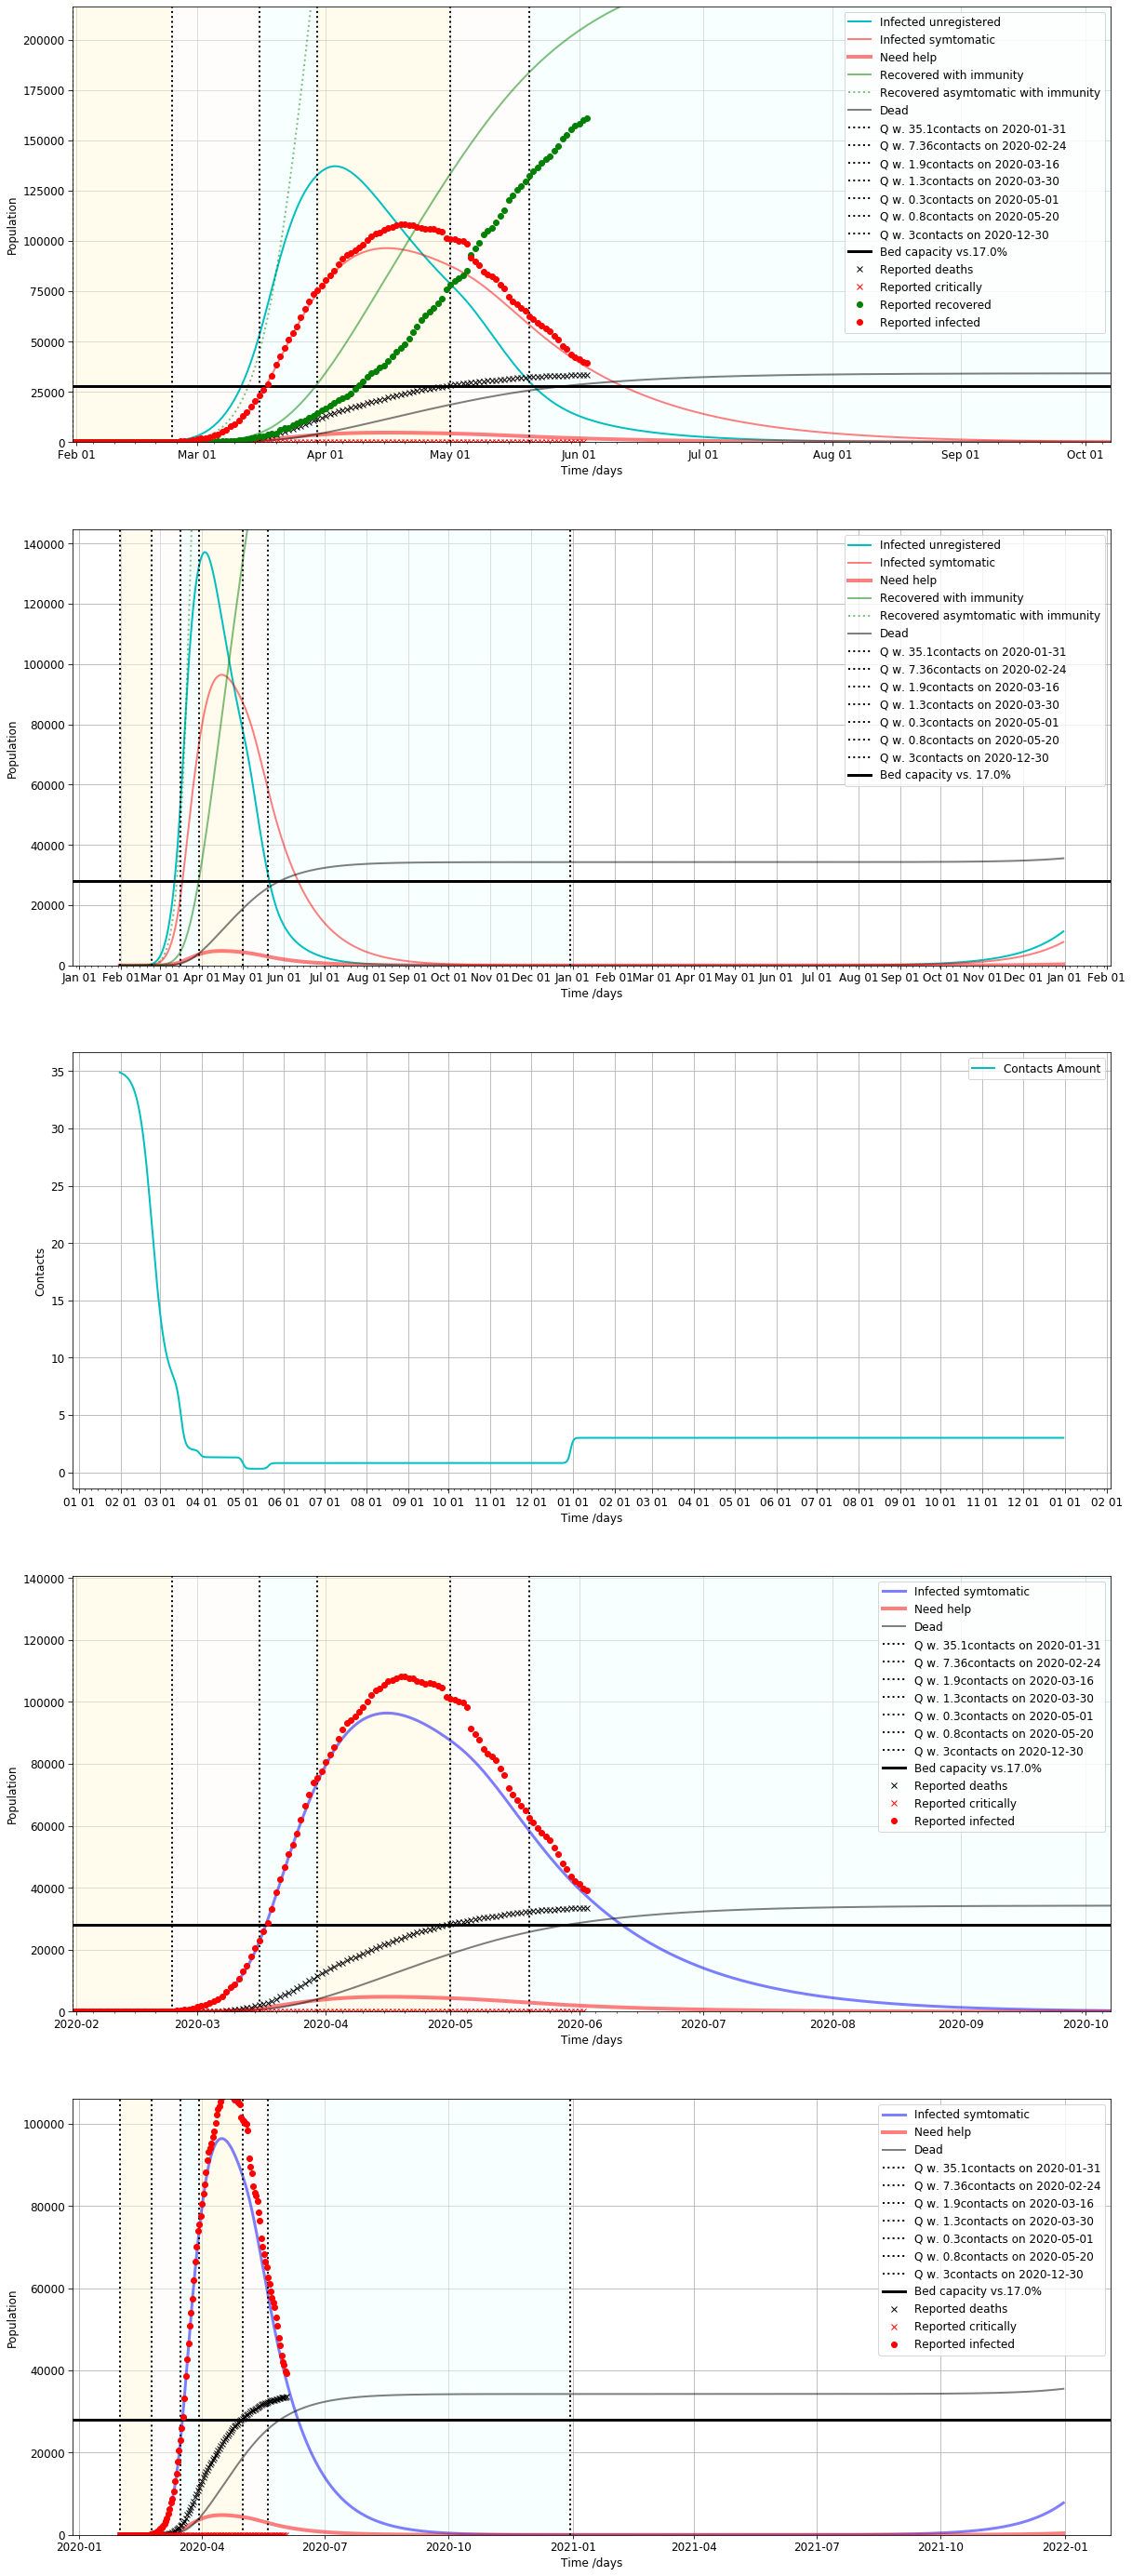

2020-06-03 Infected: 37083.0Diff: -2214.0
2020-06-03 Dead: 29043.0Diff: -4558.0
2020-06-11 Infected: 28307.0 Dead: 30343.0
2021-12-31 Prediction Dead: 35545.0
23.760895454751072 % are Ill and unregistered today
82.13608093623198 % are Recovered and unregistered today
80.34053192418854 % are Recovered unregistered total
1159868.3172572304 are Recovered total


In [177]:
##Italy

# Total population, N.
N = 60.48*1000000
#natural death rate
delta = 10.6/1000/365
#natural birth_rate https://www.macrotrends.net/countries/ITA/italy/birth-rate
A = 7.509/1000*N/365 
# Initial number of infected and recovered individuals, I0 and R0.
E0, Ia0, Is0, Iu0, R0, Ra0, D0 = 1, 0, 0, 0, 0, 0, 0
start_date = datetime.date(2020,1,31)
#start 15.02.2020

reported_critically = (0,)

#q1 : 21.02.2020 in LOMBARDIE
#q2 : 09.03.2020 in Italy
dayQuarantine=(0,24.089,45.3509-24.089) 
dateday=(
         datetime.date(2020,3,30),
         datetime.date(2020,5,1),
        datetime.date(2020,5,20),
         datetime.date(2020,12,30))

contact=(35.1,7.36,1.9,1.3,0.3,0.8,3)
deltat = (1,4.97,1.572,1,1,1,1)

#proceed_start_paramter()
proceed_start_paramter_country("Italy")


Gamma=0.0433 #0.0433107
CurlyEpsilon= 0.011#0.0152658
Phi=  0.22073
Psi= 1.

bed_capacity = 28000
death_rate_proz = 0.5#CurlyEpsilon*100
need_help_proz = 5
 
infection_probability_proz=Gamma*100
asymptom_probability_proz=(1-Phi)*100
teta_inc = 5.1
teta_sym = 11.5
recovery_day= 4*7
recovery_day_mild= 7

# Everyone else, S0, is susceptible to infection initially.
S0 = N - (E0 + Ia0 + Is0 + R0 + D0 + Ra0)

show_plot()


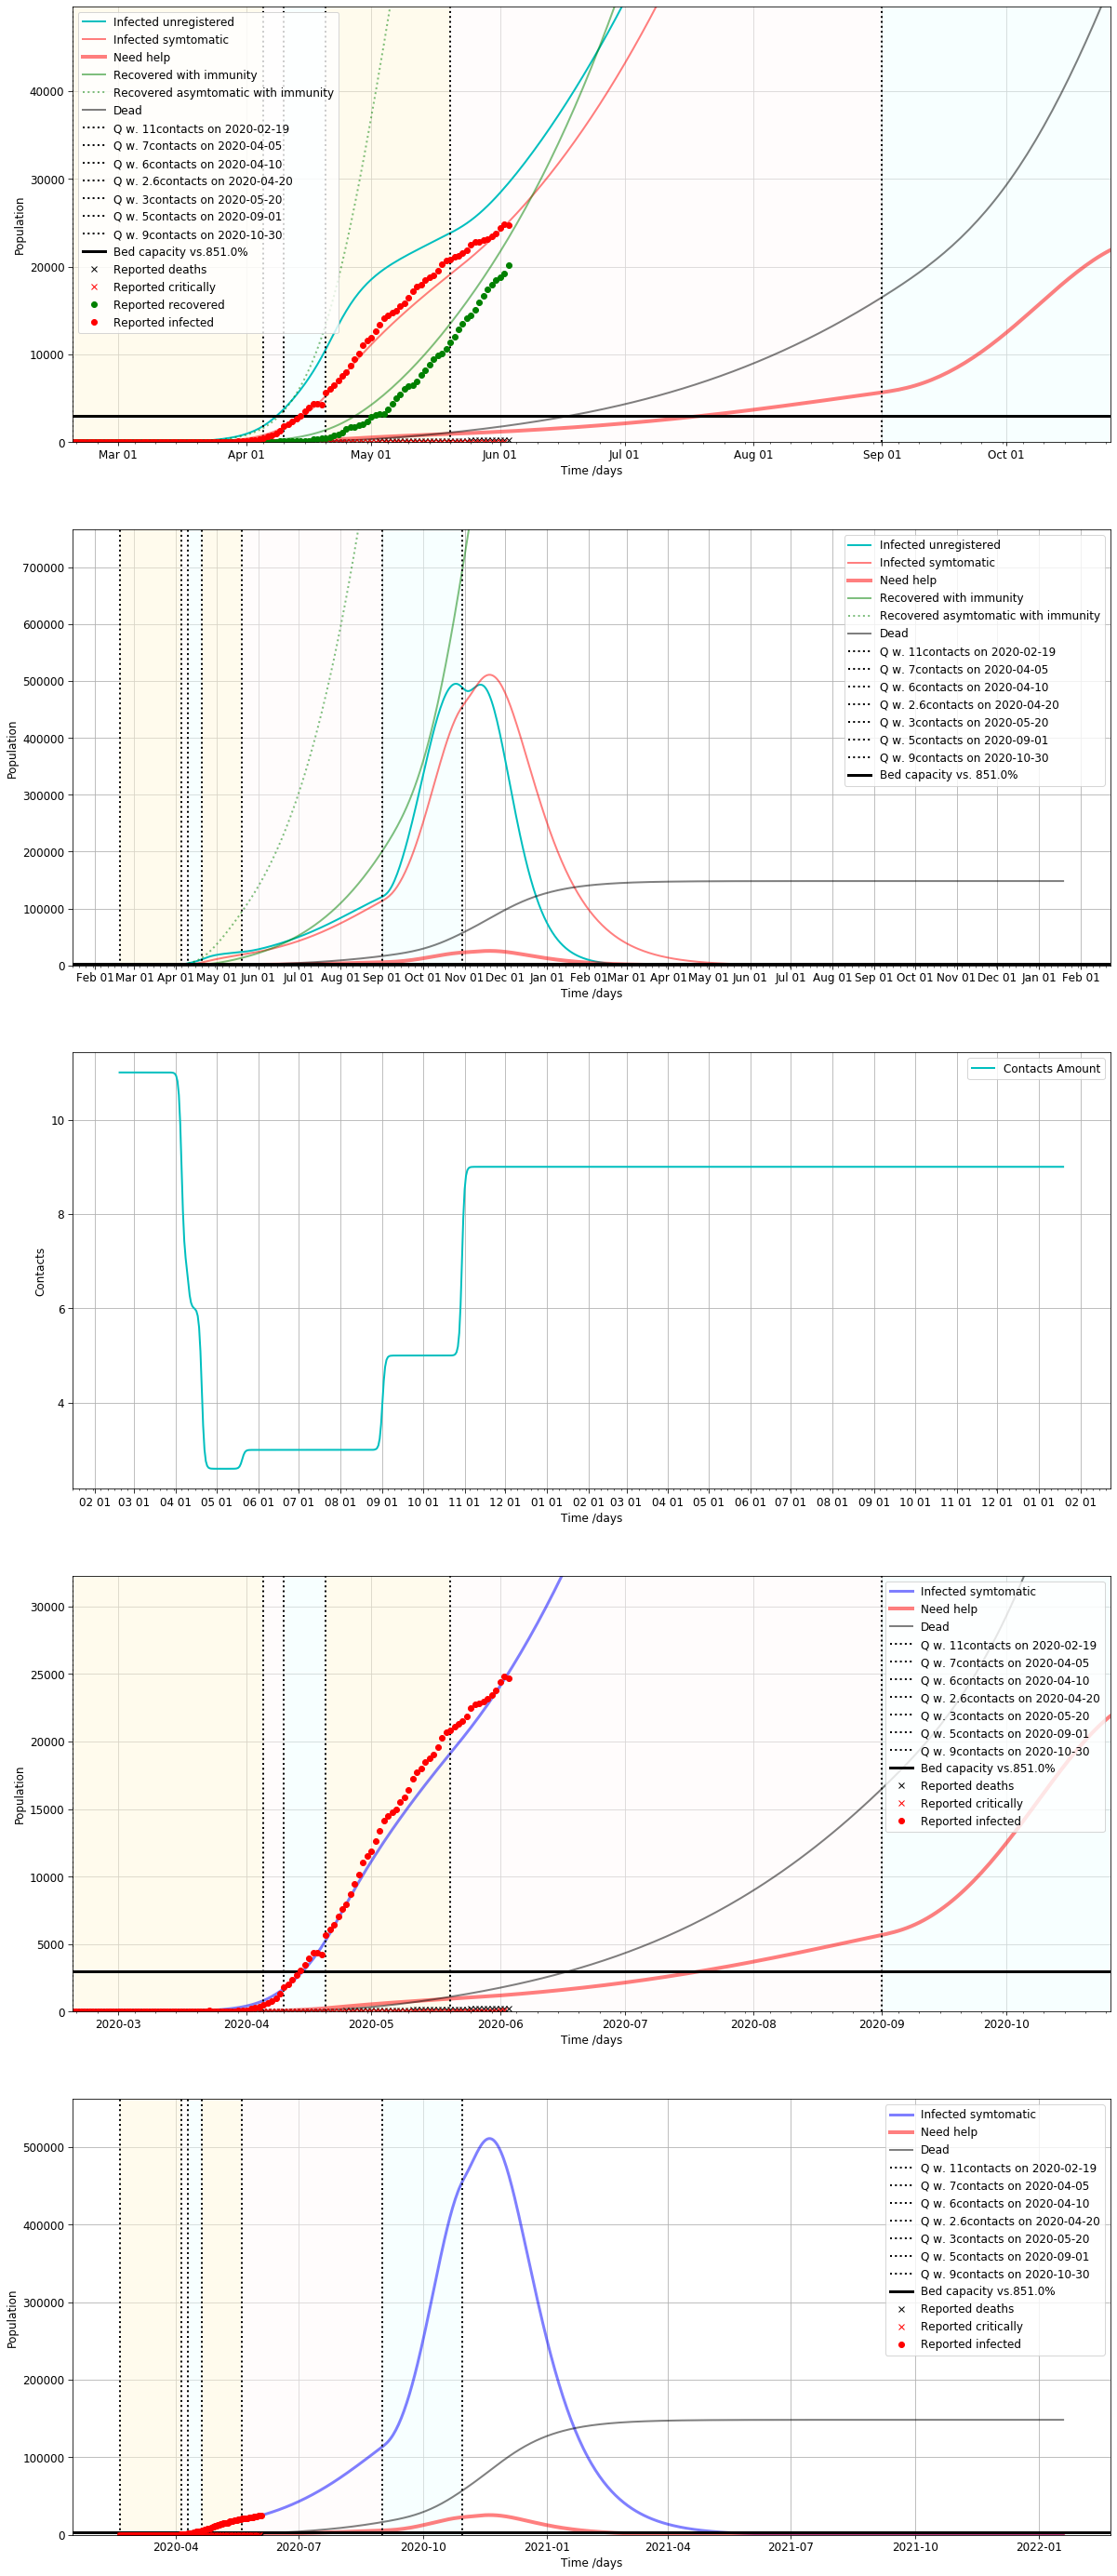

2020-06-03 Infected: 25050.0Diff: 353.0
2020-06-03 Dead: 1904.0Diff: 1656.0
2020-06-11 Infected: 29317.0 Dead: 2468.0
2022-01-19 Prediction Dead: 148312.0
54.06799838991101 % are Ill and unregistered today
86.40042032593396 % are Recovered and unregistered today
79.23548512194716 % are Recovered unregistered total
170839.92937974274 are Recovered total


In [178]:
##Belarus

# Total population, N.
N = 9.485*1000000
#natural death rate
delta = 12/1000/365
#natural birth_rate https://www.destatis.de/EN/Themes/Society-Environment/Population/Births/Tables/birth-deaths.html;jsessionid=D12FBB60A572EE37276ED5A4E5B23FE5.internet711
A = 9.5/1000*N/365
# Initial number of exposed, infected and recovered individuals.
E0, Ia0, Is0, R0, Ra0, D0 = 5, 3, 0, 0, 0, 0
Iu0=0


start_date = datetime.date(2020,2,19)

reported_critically = (92,92)



#q1 : 06.04.2020 School closed
dayQuarantine=(0,) 
contact=(11,7,6,2.6,3,5,9)
deltat = (1,1,1,1,1,1,1)

dateday=(
        datetime.date(2020,4,5), # 
        datetime.date(2020,4,10), #who in Minsk 13.04
        datetime.date(2020,4,20), #schule offen 
         datetime.date(2020,5,20),
         datetime.date(2020,9,1),
         datetime.date(2020,10,30)
         
         )
proceed_start_paramter_country("Belarus")

Gamma=0.038 #0.0433107
CurlyEpsilon= 0.0152658
Phi=  0.22073
Psi= 1.

bed_capacity = 3000
death_rate_proz = 0.26#0.17#CurlyEpsilon*100
need_help_proz = 5
 
infection_probability_proz=Gamma*100
asymptom_probability_proz=(1-Phi)*100
teta_inc = 5.1
teta_sym = 11.5
recovery_day= 7*4.5
recovery_day_mild= 7

# Everyone else, S0, is susceptible to infection initially.
S0 = N - (E0 + Ia0 + Is0 + R0 + D0 + Ra0)

show_plot()



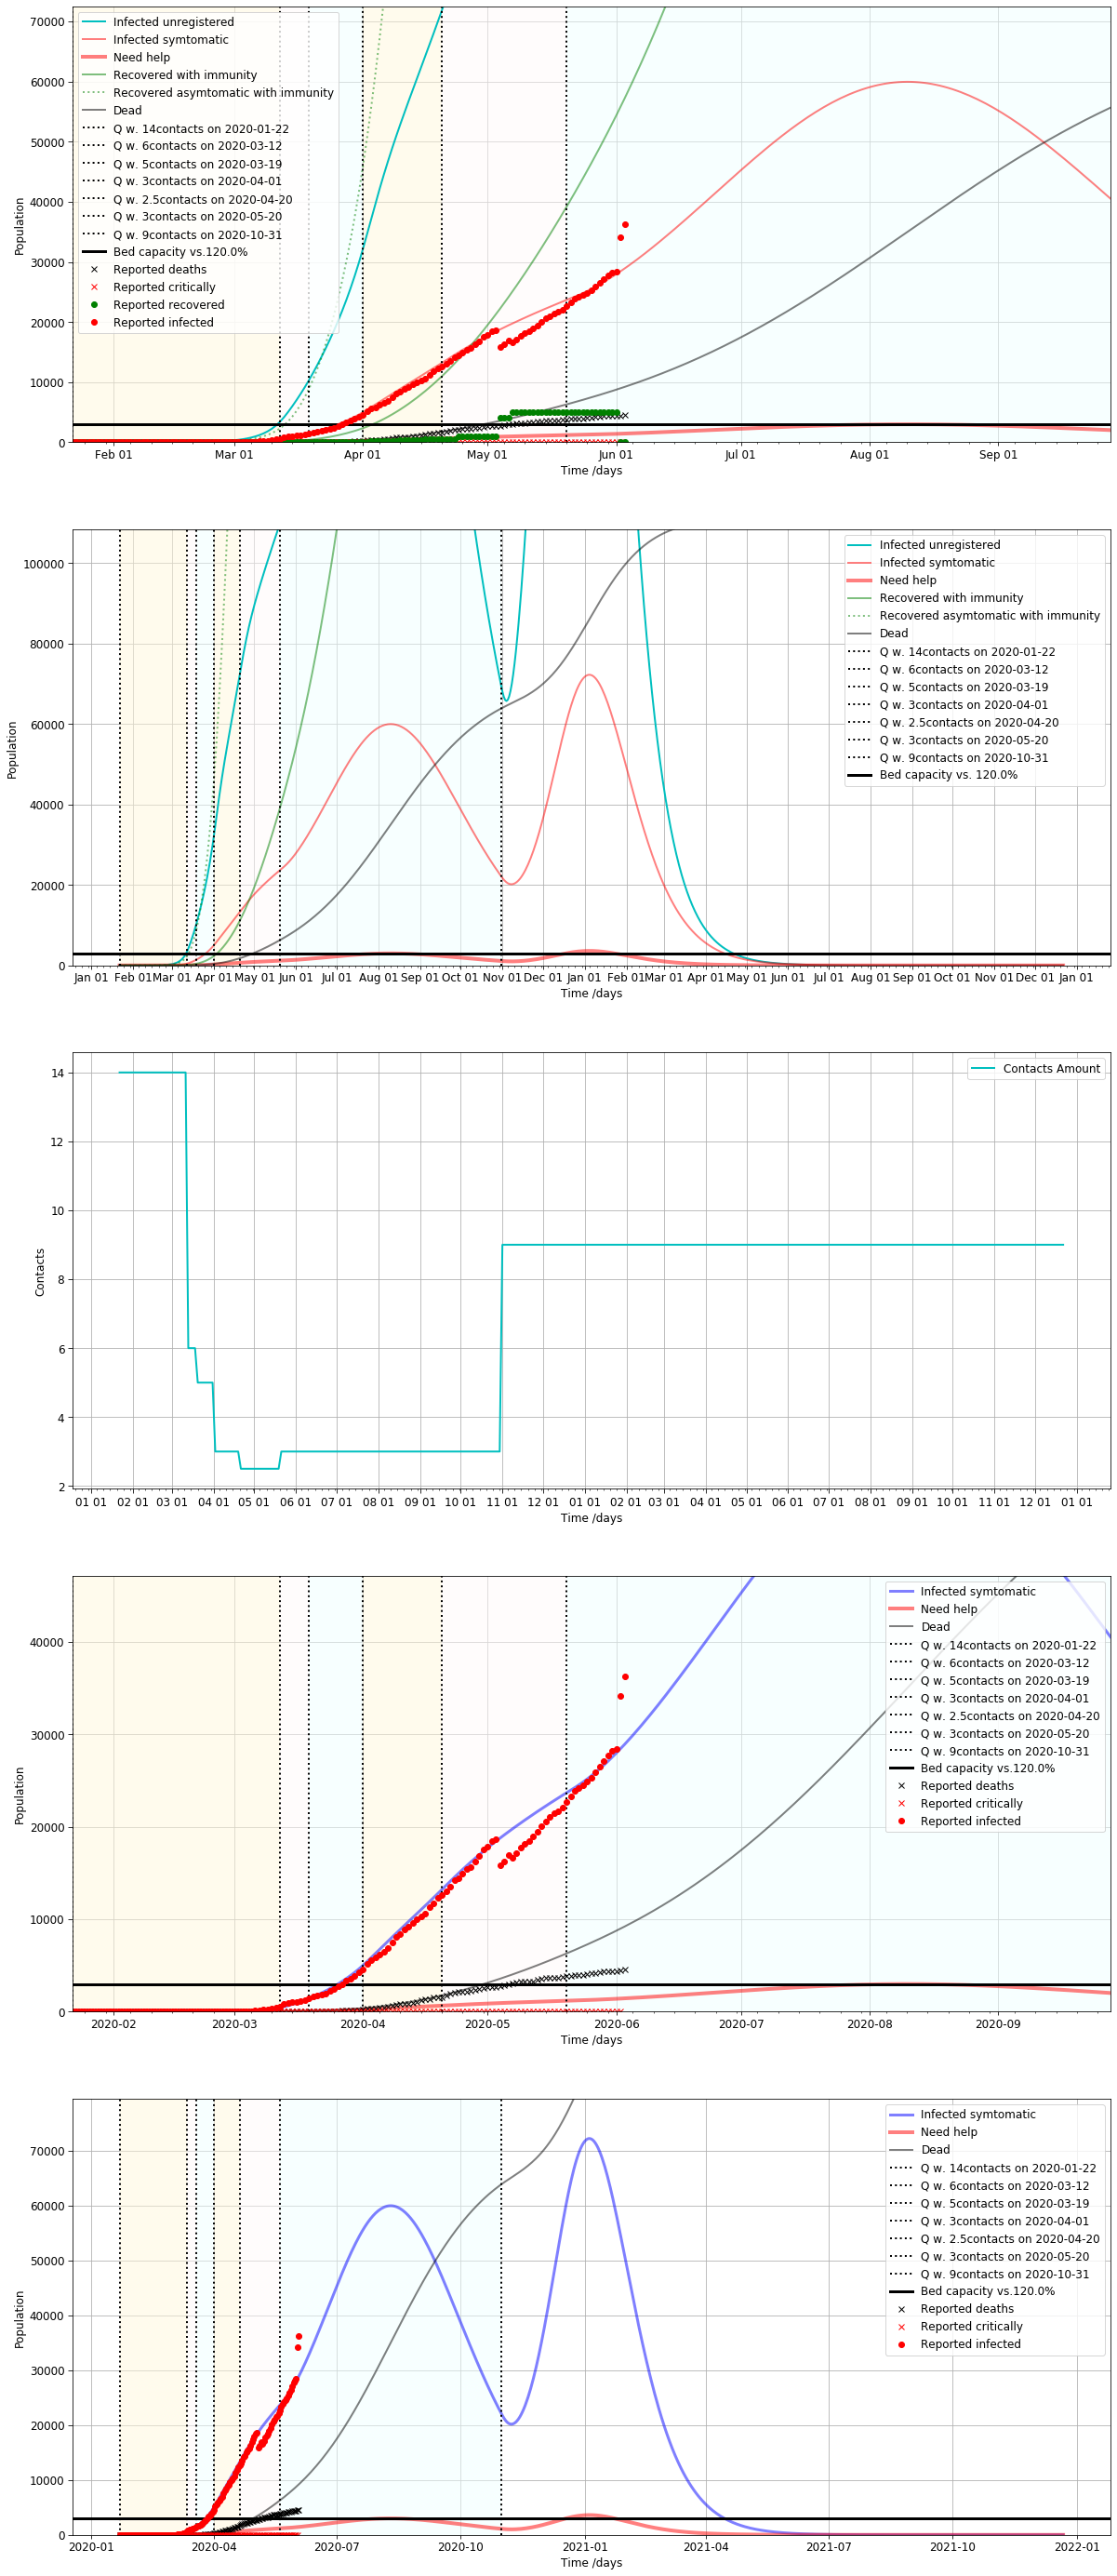

2020-06-03 Infected: 28903.0Diff: -7358.0
2020-06-03 Dead: 9210.0Diff: 4668.0
2020-06-11 Infected: 33125.0 Dead: 11191.0
2021-12-22 Prediction Dead: 111220.0
82.37241955443221 % are Ill and unregistered today
93.51790705799345 % are Recovered and unregistered today
92.11261421636738 % are Recovered unregistered total
882190.411608104 are Recovered total


In [179]:
##Sweden
#https://data.worldbank.org/indicator/SP.DYN.CDRT.IN?locations=SE
# Total population, N.
N = 10.23*1000000
#natural death rate
delta = 91/1000/365
#natural birth_rate 
A = 11.4/1000*N/365
# Initial number of exposed, infected and recovered individuals.
E0, Ia0, Is0, R0, Ra0, D0 = 1, 0, 0, 0, 0, 0
Iu0=0

start_date = datetime.date(2020,1,22)
reported_critically = (0,)


#q1 : 06.04.2020 School closed
dayQuarantine=(0,) 
contact=(14,6,5,3,2.5,3,9)
deltat = (0.1,0.1,0.1,0.1,0.1,0.1,0.1)

dateday=(
        datetime.date(2020,3,12), #10 
        datetime.date(2020,3,19), #20 #25,29 
        datetime.date(2020,4,1), # social distancing 
        datetime.date(2020,4,20), 
         datetime.date(2020,5,20),
         datetime.date(2020,10,31))
proceed_start_paramter_country("Sweden")

Gamma=0.039 #0.0433107
CurlyEpsilon= 0.0152658# in sweden its higher, as it only suvier cases get registered
#probability for registration/suvir symptoms
Phi=  0.09 #0.22073
Psi= 1.

bed_capacity = 3000
death_rate_proz = 0.8 #0.17#CurlyEpsilon*100
need_help_proz = 5
 
infection_probability_proz=Gamma*100
asymptom_probability_proz=(1-Phi)*100
teta_inc = 5.1
teta_sym = 11.5
recovery_day= 20
recovery_day_mild= 7

# Everyone else, S0, is susceptible to infection initially.
S0 = N - (E0 + Ia0 + Is0 + R0 + D0 + Ra0)

show_plot()



In [180]:
start_date = datetime.date(2020,2,19)
proceed_start_paramter_country("Belarus")
print(reported_recovered)

Start date: 2020-02-19
Start date New: 2020-01-22
Last date: 2020-06-03
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     1     3     3     3     3
     3     3     3     3     5     5     5    15    15    15    22    29
    29    32    32    32    32    47    53    53    53    53    52    53
    54    77   139   169   172   203   203   203   203   203   342   342
   494   514   577   769   938  1120  1573  1695  1740  1993  2072  2386
  2918  3117  3196  3259  3771  4388  5067  5484  6050  6406  6531  6974
  7711  8168  8807  9498  9932 10130 10620 11415 12057 12833 13528 14155
 14449 15086 15923 16660 17390 17964 18514 18776 19195 20171]
